# Statistical tests with DataRobot and Apache Airflow integration

## Summary

This notebook presents an example workflow for carrying out statistical tests, notify stakeholders of any issues via Slack, and generate automated compliance documentation with the test results.

This notebook will demonstrate how to create a pipeline of statistical tests at different stages of the model development cycle, and integrate with Apache Airflow:

1. Exploratory statistical tests as part of model training
2. Score a DataRobot model
3. Run any arbitrary statistical tests
4. Register the test results to the model version
5. Generate automated compliance documentation using customized templates
6. Create the pipeline with Apache Airflow

## Setup

### Import libraries

In [18]:
import os

import datarobot as dr
import datarobot_bp_workshop as bp
import pandas as pd
from storage.airflow.dags.datarobot_kv_helper import DataRobotKeyValueHelper
from storage.airflow.dags.nodes import test_autocorrelation, test_cooks_distance

### Bind variables

In [2]:
# These variables can aso be fetched from a secret store or config files
DATAROBOT_ENDPOINT = "https://app.datarobot.com/api/v2"
# The URL may vary depending on your hosting preference, the above example is for DataRobot Managed AI Cloud

DATAROBOT_API_TOKEN = os.environ.get("DATAROBOT_API_TOKEN")
# The API Token can be found by click the avatar icon and then </> Developer Tools

### Connect to DataRobot

You can read more about different options for [connecting to DataRobot from the client](https://docs.datarobot.com/en/docs/api/api-quickstart/api-qs.html).

In [3]:
client = dr.Client()

## Conduct a statistical test for data exploration

### Create custom task for statistical test

DataRobot allows custom tasks to be used as part of [ComposableML](https://docs.datarobot.com/en/docs/modeling/special-workflows/cml/cml-overview.html#composable-ml-overview).

A wide variety of custom task templates can be found in the Github repo: https://github.com/datarobot/datarobot-user-models/tree/master/task_templates

This example implements [a simple one-sampled t-test as a custom task](./storage/airflow/t-test/custom.py), which users can share with teammates and reuse as part of any blueprints that support ComposableML.

In [4]:
custom_task_name = "t-test"
custom_task_desc = "An example one-sampled t-test"
custom_task_folder = "./storage/airflow/t-test"
transform = dr.CustomTask.create(
    name=custom_task_name,
    target_type="Transform",
    language="python",
    description=custom_task_desc,
)
task_version = dr.CustomTaskVersion.create_clean(
    custom_task_id=transform.id,
    base_environment_id="65aabe3fabe8ef70929b4737",
    folder_path=custom_task_folder,
)
transform.refresh()

### Create blueprint that utilizes the custom task

In [5]:
w = bp.Workshop()
t_test = w.CustomTasks.CUSTOMT_65a9ac05769a6468219b45be(w.TaskInputs.NUM)

Set the parameters for the custom task, such as the column name and $\mu$ for the one sample t-test

In [6]:
project_id = "657a7c69a2930e16b2ef83a0"
column_name = "int_rate"
mu = 0.1
# t_test.set_task_parameters(user_param___column_name=column_name, user_param___mu=mu)
client = dr.Client()
resp = client.post(
    "userBlueprintsTaskParameters",
    json={
        "taskCode": "CUSTOMT",
        "outputMethod": "T",
        "projectId": project_id,
        "taskParameters": [
            {"paramName": "np_dtype_fix", "newValue": False},
            {"paramName": "user_param___column_name", "newValue": column_name},
            {"paramName": "user_param___mu", "newValue": mu},
            {"paramName": "version_id", "newValue": "65ab0fbc6d209c96789b4600"},
        ],
    },
)

If the above API route reports error, please use the GUI to confirm on the parameters.
![](storage/images/custom_task.png)

In [7]:
# Define the preprocessing path for categorical features
pdm3 = w.Tasks.PDM3(w.TaskInputs.CAT)  # One-hot encoding
pdm3.set_task_parameters(cm=50000, sc=10)

# Define the preprocessing path for numeric features
ndc = w.Tasks.NDC(w.TaskInputs.NUM)  # Numeric data cleaning
rdt5 = w.Tasks.RDT5(ndc)  # Smooth ridit transform

# Define the preprocessing path for text features
ptm3 = w.Tasks.PTM3(w.TaskInputs.TXT)  # Word-gram occurrence matrix
ptm3.set_task_parameters(d2=0.2, mxf=20000, d1=5, n="l2", id=True)

Matrix of word-grams occurrences (PTM3)

Input Summary: Text Data
Output Method: TaskOutputMethod.TRANSFORM

Task Parameters:
  min_df (d1) = 5
  max_df (d2) = 0.2
  use_idf (id) = True
  max_features (mxf) = 20000
  norm (n) = 'l2'

In [8]:
kerasc = w.Tasks.KERASC(rdt5, t_test, ptm3)
kerasc_blueprint = w.BlueprintGraph(kerasc, name="Custom Keras BP (1 layer: 64 units) with T-test")

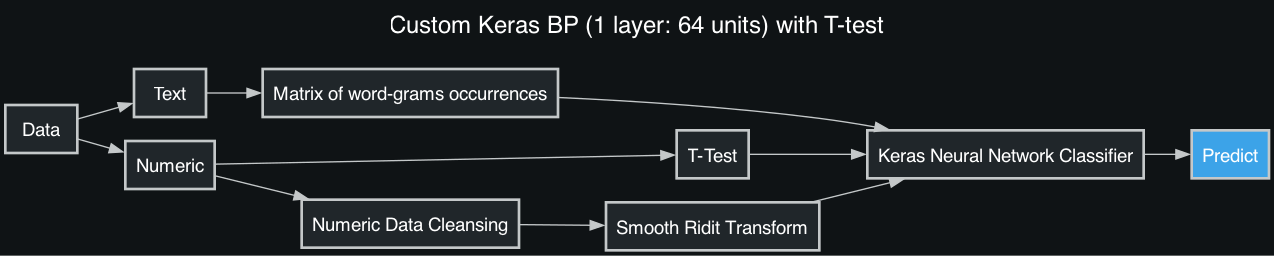

In [9]:
kerasc_blueprint.show()

### Run the blueprint and download the artifacts generated by the statistical test

In [ ]:
kerasc_blueprint.train(project_id)

In [10]:
model_id = "65a84eed247c8719f96f14f0"
model = dr.Model.get(project_id, model_id)
model.download_training_artifact("artifact_test.tar.gz")

## Conduct a statistical test on model predictions

### Score with a deployed model

In [11]:
df_score_input = pd.read_csv("./storage/data/10K_LC_predictions.csv")
deployment = dr.Deployment.get("657b0f46f3df7e03a1fc728b")
df_score_output = deployment.predict_batch(df_score_input)

Streaming DataFrame as CSV data to DataRobot
Created Batch Prediction job ID 65aebe9400e2a959a54b38cf
Waiting for DataRobot to start processing
Job has started processing at DataRobot. Streaming results.


### Conduct a statistical test

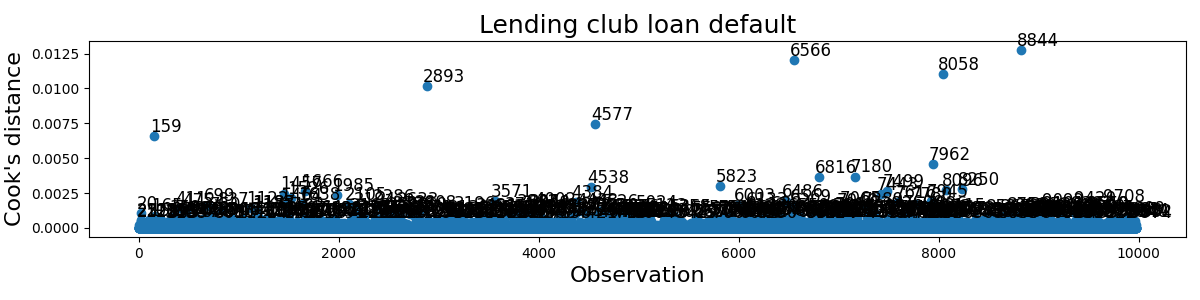

In [12]:
im = test_cooks_distance(
    {"Lending Club Loan Default": df_score_output}, {"target_column": "is_bad"}
)
im

In [13]:
im.save("./storage/images/cooks.png")

In [14]:
df_score_output.rename(columns={"is_bad_PREDICTION_x": "is_bad_PREDICTION"}, inplace=True)
summary, im = test_autocorrelation(
    {"Lending Club Loan Default": df_score_output}, {"target_column": "is_bad"}
)

In [15]:
summary

,lag,d_stat,lb_stat,lb_pvalue,bp_stat,bp_pvalue
0,1,1.7439,0.1293,0.719204,0.1292,0.719245
1,2,NaN,0.5251,0.769083,0.5249,0.769159
2,3,NaN,2.8992,0.407433,2.8978,0.407654
3,4,NaN,3.0978,0.541597,3.0963,0.541845
4,5,NaN,3.7470,0.586392,3.7450,0.586682
5,6,NaN,3.7470,0.710874,3.7450,0.711138
6,7,NaN,5.8352,0.559115,5.8314,0.559569
7,8,NaN,5.8677,0.662046,5.8639,0.662479
8,9,NaN,5.8677,0.753081,5.8639,0.753463
9,10,NaN,5.8753,0.825629,5.8714,0.825948


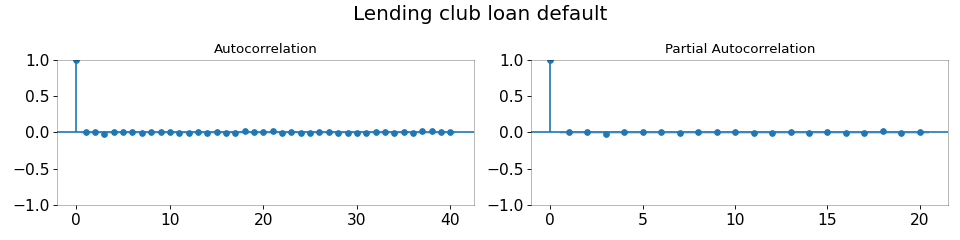

In [16]:
im

In [17]:
im.save("./storage/images/autocorrelation.png")

### Register the statistical test results with a model version

In [19]:
model_package_id = "65a83e8c1ee3ab569914ce95"
drkv = DataRobotKeyValueHelper(
    datarobot_uri="https://app.datarobot.com",
    datarobot_token=DATAROBOT_API_TOKEN,
    entity_id=model_package_id,
)

In [22]:
kv_artifacts = {}
kv_artifacts["cooks"] = "./storage/images/cooks.png"
kv_artifacts["autocorrelation"] = "./storage/images/autocorrelation.png"

In [23]:
for k, v in kv_artifacts.items():
    drkv.set_artifact(k, v, "image")

{"message": "The name is already in use for the entity ID"}
{"message": "The name is already in use for the entity ID"}


### Customize the compliance documentation template

The [template builder](https://docs.datarobot.com/en/docs/modeling/analyze-models/compliance/template-builder.html#template-builder) provides a visual editor of documentation templates. The template itself is in JSON format:

In [25]:
template = pd.read_json("./storage/docs/template.json")
template

,title,locked,description,instructions,type,content_id,sections,regular_text,highlighted_text
0,How To Use This Document,1.0,,"{'owner': '', 'user': ''}",datarobot,HOW_TO_USE,NaN,NaN,NaN
1,Table of Contents,1.0,NaN,NaN,table_of_contents,NaN,NaN,NaN,NaN
2,Statistical Tests,NaN,None,NaN,custom,NaN,[],,Cooks distance\n{{ dr_key_value | key=cooks }}...


### Generate a compliance documentation for the model version with statistical test results

In [28]:
doc_type = "AUTOPILOT_SUMMARY"
file_format = "docx"
template_id = "65ac954229b85883b07b3c28"
doc = dr.AutomatedDocument(
    document_type="MODEL_COMPLIANCE",
    entity_id=model_package_id,
    output_format="docx",
    locale="EN_US",
    template_id=template_id,
    filepath="./storage/docs/example_doc.docx",
)
doc.generate()
doc.download()

<Response [200]>

## DataRobot provider for Apache Airflow

With the highly scalable and modular architecture, Apache Airflow is a popular choice of handling pipelines like the statistical tests shown above in production.
DataRobot integrates with Airflow through the [DataRobot provider for Apache Airflow](https://github.com/datarobot/airflow-provider-datarobot) and a step by step tutorial is available to help you get started: https://docs.datarobot.com/en/docs/more-info/how-to/apache-airflow.html

After the DataRobot connection is set up on Airflow, the `DataRobotHook` function can be used to authenticate the Python client and other DataRobot packages, enabling the user to access any additional functions from the Python client.

```python
from datarobot_provider.hooks.datarobot import DataRobotHook
datarobot_conn_id = 'datarobot_default'
DataRobotHook(datarobot_conn_id).run()
```

The [Airflow pipeline](./airflow/dags/dr_stat_test.py) script provides an example DAG flow that incorporates the above statistical tests and subsequent automatic model documentation generation.

!['airflow dag'](./storage/images/airflow.png)